## This notebook check the hexapod state transitions and move/offset commands
## It also checks the LUT against the input polynomials, before and after a slew

This notebook works with both hexapods.

Prerequisits:

The MTMount and the MTRotator must send telemetry for mount azimuth and elevation and rotation angle.

In [1]:
from lsst.ts import salobj
import asyncio
import os
import yaml

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.idl.enums import MTPtg
from lsst.ts.idl.enums import MTHexapod

from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from lsst_efd_client import EfdClient

import types

In [2]:
#os.environ["LSST_DDS_HISTORYSYNC"] = "30"

To switch between the hexapods, change the cell below.

In [3]:
import os
print(os.environ["OSPL_URI"])
if os.environ.get("LSST_DDS_ALIGNER", "false") != "false":
    print("LSST_DDS_ALIGNER is mis-configured")

file:///home/hdrass/WORK/ts_ddsconfig/config/ospl-shmem.xml


In [4]:
script = salobj.Controller("Script", index=42658887)

In [5]:
await asyncio.gather(script.start_task)

[None]

In [6]:
# Dict of short name: full SAL component name and index;
# comment out an etry to avoid making the associated remote:
remote_names = dict(
    # Always comment out one of the two hexapods:
    mthex=f"MTHexapod:{MTHexapod.SalIndex.CAMERA_HEXAPOD}",
    # mthex=f"MTHexapod:{MTHexapod.SalIndex.M2_HEXAPOD}",
    mtptg="MTPtg",
    mtrot="MTRotator",
    mtm="MTMount"
    )

In [7]:
remotes_dict = {}
for short_name, sal_name_index in remote_names.items():
    sal_name, index = salobj.name_to_name_index(sal_name_index)
    remote = salobj.Remote(domain=script.domain, name=sal_name, index=index)
    remotes_dict[short_name] = remote 
r = types.SimpleNamespace(**remotes_dict)
del remotes_dict  # use vars® instead
hexId = r.mthex.salinfo.index  # or just use the long form

In [8]:
print(hexId)

1


In [9]:
# Wait for all remotes to start
for remote in vars(r).values():
    await remote.start_task

# Wait for a heartbeat from each remote
for name, remote in vars(r).items():
    try:
        await remote.evt_heartbeat.next(flush=False, timeout=5)
    except asyncio.TimeoutError:
         print(f"No heartbeat seen for {remote.salinfo.name_index}")

rotation DDS read queue is filling: 28 of 100 elements
electrical DDS read queue is full (100 elements); data may be lost
motors DDS read queue is filling: 29 of 100 elements
application DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 29 of 100 elements
actuators DDS read queue is full (100 elements); data may be lost
ccwFollowingError DDS read queue is filling: 31 of 100 elements
timeAndDate DDS read queue is filling: 26 of 100 elements
mountStatus DDS read queue is filling: 28 of 100 elements
mountPosition DDS read queue is filling: 29 of 100 elements
currentTargetStatus DDS read queue is filling: 30 of 100 elements


### Test the hexapod state transitions. If the hexapod is already enabled, disable then enable it.

In [10]:
state = await r.mthex.evt_summaryState.aget(timeout=5)
print('staring with: hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
if state.summaryState == 2:
    await salobj.set_summary_state(r.mthex, salobj.State.DISABLED) #disable hex

staring with: hex state State.ENABLED 2021-07-09 19:07:11.503803648


In [11]:
await salobj.set_summary_state(remote=r.mthex, state=salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [12]:
await salobj.set_summary_state(remote=r.mthex, state=salobj.State.DISABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>]

In [13]:
await salobj.set_summary_state(r.mthex, salobj.State.ENABLED, settingsToApply="default") #enable hex

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [14]:
await salobj.set_summary_state(r.mthex, salobj.State.ENABLED) #enable hex

[<State.ENABLED: 2>]

## Start the EFD client

In [15]:
#client = EfdClient('summit_efd')
client = EfdClient('ncsa_teststand_efd')

In [16]:
# the next line only work if information were sent to the EFD during the time span "timedelta"!
#we cannot get time series data from DDS. We have to query the EFD
#to check messages in Kafka, go to https://lsst-kafka-0-nts-efd.ncsa.illinois.edu/
csc_index = 1
end = Time(datetime.now(), scale='tai')
start = end - timedelta(hours=6)
while True: #may need to wait a few seconds before event shows up in EFD
    dfe = await client.select_time_series('lsst.sal.MTHexapod.logevent_summaryState', '*', start, end, csc_index)
    if len(dfe)>0:
        break

In [17]:
dfe

,MTHexapodID,priority,private_efdStamp,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,summaryState
2021-07-09 18:31:50.137000+00:00,1,0,1.625855e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,37,1.625856e+09,1
2021-07-09 18:32:28.693000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,38,1.625856e+09,5
2021-07-09 18:32:30.006000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,39,1.625856e+09,1
2021-07-09 18:32:32.530000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,40,1.625856e+09,2
2021-07-09 18:37:54.610000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,41,1.625856e+09,1
2021-07-09 18:37:56.734000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,42,1.625856e+09,5
2021-07-09 18:37:57.341000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,43,1.625856e+09,1
2021-07-09 18:37:57.644000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,44,1.625856e+09,2
2021-07-09 18:44:00.294000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,45,1.625856e+09,1
2021-07-09 18:44:00.395000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,46,1.625856e+09,5


## Check that the other components are enabled or, if not, enable them 

In [18]:
await salobj.set_summary_state(r.mtm, salobj.State.ENABLED)

[<State.ENABLED: 2>]

In [19]:
await salobj.set_summary_state(r.mtrot, salobj.State.ENABLED)

[<State.ENABLED: 2>]

In [20]:
await salobj.set_summary_state(r.mtptg, salobj.State.ENABLED)

[<State.ENABLED: 2>]

## Check that the configurations and that the needed telemetry is comming in:

In [22]:
#Check some configurations for the hexapod
hexConfig = await r.mthex.evt_configuration.aget(timeout=10.)
print("pivot at (%.0f, %.0f, %.0f) microns "%(hexConfig.pivotX, hexConfig.pivotY, hexConfig.pivotZ))
print("maxXY = ", hexConfig.maxXY, "microns, maxZ= ", hexConfig.maxZ, " microns")
print("maxUV = ", hexConfig.maxUV, "deg, maxW= ", hexConfig.maxW, " deg")

pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg


In [23]:
end = Time(datetime.now())
start = end - timedelta(hours=3)
#logeventTarget = await client.select_time_series('lsst.sal.MTMount.logevent_target', '*', start.tai, end.tai)
#With this we can get the elevation when a controller is running
MTMountElevation = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start.tai, end.tai)
MTMountAzimuth = await client.select_time_series('lsst.sal.MTMount.azimuth', '*', start.tai, end.tai)
MTRotPosition = await client.select_time_series('lsst.sal.MTRotator.rotation', '*', start.tai, end.tai)

In [24]:
#get the elevation into a variable
mtmElev=MTMountElevation.actualPosition
print("Mount elevation from the EFD:")
mtmElev

Mount elevation from the EFD:


2021-07-09 16:09:23.417000+00:00    75
2021-07-09 16:09:23.618000+00:00    75
2021-07-09 16:09:23.819000+00:00    75
2021-07-09 16:09:24.019000+00:00    75
2021-07-09 16:09:24.220000+00:00    75
                                    ..
2021-07-09 19:09:22.311000+00:00    75
2021-07-09 19:09:22.512000+00:00    75
2021-07-09 19:09:22.712000+00:00    75
2021-07-09 19:09:22.913000+00:00    75
2021-07-09 19:09:23.114000+00:00    75
Name: actualPosition, Length: 53783, dtype: int64

In [25]:
mtmAzimuth = MTMountAzimuth.actualPosition
print("Mount azimuth from the EFD:")
mtmAzimuth

Mount azimuth from the EFD:


2021-07-09 16:09:23.417000+00:00   -3.552714e-15
2021-07-09 16:09:23.617000+00:00   -3.552714e-15
2021-07-09 16:09:23.818000+00:00   -3.552714e-15
2021-07-09 16:09:24.019000+00:00   -3.552714e-15
2021-07-09 16:09:24.220000+00:00   -3.552714e-15
                                        ...     
2021-07-09 19:09:22.511000+00:00   -3.552714e-15
2021-07-09 19:09:22.712000+00:00   -3.552714e-15
2021-07-09 19:09:22.913000+00:00   -3.552714e-15
2021-07-09 19:09:23.114000+00:00   -3.552714e-15
2021-07-09 19:09:23.314000+00:00   -3.552714e-15
Name: actualPosition, Length: 53784, dtype: float64

In [26]:
mtrotPosition = MTRotPosition.actualPosition
print("MTRotator positon from the EFD:")
mtrotPosition

MTRotator positon from the EFD:


2021-07-09 16:09:23.440000+00:00   -2.911691e-07
2021-07-09 16:09:23.541000+00:00    7.065940e-07
2021-07-09 16:09:23.641000+00:00   -9.296782e-07
2021-07-09 16:09:23.742000+00:00   -6.678588e-07
2021-07-09 16:09:23.843000+00:00    6.430900e-07
                                        ...     
2021-07-09 19:09:22.935000+00:00    6.157509e-08
2021-07-09 19:09:23.035000+00:00    2.109197e-07
2021-07-09 19:09:23.136000+00:00   -1.447755e-06
2021-07-09 19:09:23.236000+00:00    1.438628e-06
2021-07-09 19:09:23.337000+00:00    8.799171e-07
Name: actualPosition, Length: 106956, dtype: float64

# Check the move behavior when LUT is disabled.

In [27]:
lutMode = await r.mthex.evt_compensationMode.aget(timeout=10)
print("Compsensation mode enabled?",lutMode.enabled)

Compsensation mode enabled? False


In [28]:
async def printPosition(hex):
    pos = await r.mthex.tel_application.next(flush=True, timeout=10.)
    print("Current Hexapod position")
    print(" ".join(f"{p:10.2f}" for p in pos.position))
await printPosition(hex)

Current Hexapod position
     -0.03      -0.00      -0.05       0.00       0.00      -0.00


In [29]:
test_message = "Camera Hexapod Integration Test"

In [30]:
#This command is to set the Hexapod to zero position
now = datetime.now()
script.log.info(f"START- {test_message} -- LVV-T1600 -- Move to Zero- Starting time: {now} UTC")
await r.mthex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

In [31]:
#To stop the Hexapod
await r.mthex.cmd_stop.set_start()

If you want to observe the motions in chronograf, consider using "AND MTHexapodID={hexId}" to filter out telemetry from the other hexapod

In [32]:
now = datetime.now()
print(now)
script.log.info(f"START- {test_message} -- LVV-T1600 Compensation mode test Step 17- Starting time: {now} UTC")
r.mthex.evt_inPosition.flush()
for step in range(5,-1,-1):
    await r.mthex.cmd_move.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    while True:
        state = await r.mthex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break    

2021-07-09 19:09:37.677212
hex in position? False 2021-07-09 19:10:14.725417216
hex in position? True 2021-07-09 19:10:15.535047168
hex in position? False 2021-07-09 19:10:15.635905792
hex in position? True 2021-07-09 19:10:15.737510144
hex in position? False 2021-07-09 19:10:16.041056256
hex in position? True 2021-07-09 19:10:16.142476800
hex in position? False 2021-07-09 19:10:16.446252800
hex in position? True 2021-07-09 19:10:16.547409664
hex in position? False 2021-07-09 19:10:16.850181632
hex in position? True 2021-07-09 19:10:16.951853568
hex in position? False 2021-07-09 19:10:17.255164672
hex in position? True 2021-07-09 19:10:17.356537088


In [33]:
await printPosition(hex)

Current Hexapod position
      0.04       0.03      -0.03      -0.00      -0.00      -0.00


In [35]:
r.mthex.evt_inPosition.flush()
for step in [1,2,3,-3,-2,-1]:
    #according to XML, units are micron and degree
    await r.mthex.cmd_offset.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    while True:
        state = await r.mthex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break
     
    await printPosition(r.mthex)
    
    end = Time(datetime.now(), scale='tai')

hex in position? False 2021-07-09 19:10:57.477750784
hex in position? True 2021-07-09 19:10:57.680238848
Current Hexapod position
      0.01      -0.04     200.04       0.00       0.00       0.00
hex in position? False 2021-07-09 19:10:57.882856192
hex in position? True 2021-07-09 19:10:58.186420736
Current Hexapod position
     -0.02      -0.04     400.05       0.00       0.00       0.00
hex in position? False 2021-07-09 19:10:58.389729024
hex in position? True 2021-07-09 19:10:58.794820608
Current Hexapod position
     -0.00       0.00     700.03       0.00       0.00       0.00
hex in position? False 2021-07-09 19:10:58.996489472
hex in position? True 2021-07-09 19:10:59.401220352
Current Hexapod position
      0.01       0.03     400.00       0.00      -0.00      -0.00
hex in position? False 2021-07-09 19:10:59.603844352
hex in position? True 2021-07-09 19:10:59.908104192
Current Hexapod position
      0.05      -0.05     200.01      -0.00      -0.00       0.00
hex in position? Fal

In [36]:
start = end - timedelta(seconds=30)
df = await client.select_time_series('lsst.sal.MTHexapod.actuators', '*', start, end, csc_index)
#idx= df.MTHexapodID==1
#df = df[idx]

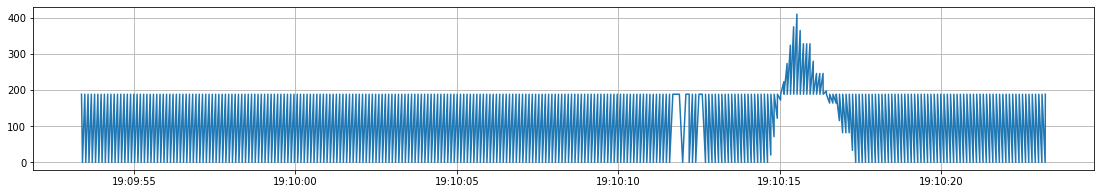

In [37]:
fig, ax = plt.subplots(figsize=(19,3))
plt.plot(df.calibrated0)
plt.grid()

### When the LUT is enabled

In [48]:
await r.mthex.cmd_setCompensationMode.set_start(enable=1, timeout=10)
lutMode = r.mthex.evt_compensationMode.get()
print("compsensation mode enabled?",lutMode.enabled)

compsensation mode enabled? True


In [ ]:
#Switch compensation mode off:
await r.mthex.cmd_setCompensationMode.set_start(enable=0, timeout=10)
lutMode =  r.mthex.evt_compensationMode.get()
print("compsensation mode enabled?",lutMode.enabled)

In [50]:
await printPosition(hex)
a = r.mthex.evt_compensationOffset.get()
print(a.elevation,a.azimuth,a.rotation,a.temperature,a.x,a.y,a.z,a.u,a.v,a.w)

Current Hexapod position
     -0.00       0.02     100.05       0.00       0.00      -0.00
75.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


In [47]:
async def printUncompensatedAndCompensated(hex):
    posU =  r.mthex.evt_uncompensatedPosition.get()
    print('Uncompensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posU, i) for i in 'xyz']), end = '    ')
    print(" ".join(f"{p:10.6f}" for p in [getattr(posU, i) for i in 'uvw']),'  ',
         pd.to_datetime(posU.private_sndStamp, unit='s'))    
    posC = r.mthex.evt_compensatedPosition.get()
    print('Compensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posC, i) for i in 'xyz']), end = '     ')
    print(" ".join(f"{p:10.6f}" for p in [getattr(posC, i) for i in 'uvw']),'  ',
         pd.to_datetime(posC.private_sndStamp, unit='s'))

await printUncompensatedAndCompensated(hex)

Uncompensated position
      0.00       0.00     100.00      0.000000   0.000000   0.000000    2021-07-09 19:11:00.012217856
Compensated position
      0.00       0.00     100.00       0.000000   0.000000   0.000000    2021-07-09 19:11:00.012440320


The inputs to the LUT are currently -
* elevation (from mount telemetry) 
* temperature (mount truss? not implemented yet)
* azimuth (hexapod supports compensation for this input, but model coefficients are not yet configured)
* rotator angle (hexapod supports compensation for this input, but model coefficients are not yet configured

In [ ]:
#Only works when mount or mount simulator are active.
#mountAngle = await mount.tel_elevation.aget(timeout=10.)
#print("mount elevation angle", mountAngle.angleActual)
#elev = mountAngle.angleActual

In [ ]:
#To set the elevation for a controller
#mount.evt_target.set_put(elevation=45)

In [ ]:
elevationFixed=80.0

In [ ]:
LUTfile = '%s/notebooks/ts_config_mttcs/MTHexapod/v1/default.yaml'%(os.environ["HOME"])
with open(LUTfile, 'r') as stream:
    aa = yaml.safe_load(stream)
if r.mthex.salinfo.sal_name == CAMERA_HEXAPOD:
    elevCoeff = aa['camera_config']['elevation_coeffs']
    tCoeff = aa['camera_config']['temperature_coeffs']
elif r.mthex.salinfo.sal_name == M2_HEXAPOD:
    elevCoeff = aa['m2_config']['elevation_coeffs']
    tCoeff = aa['m2_config']['temperature_coeffs']

In [ ]:
async def printPredictedComp(elevCoeff, elev):
    '''
    This function deals with the elevation component of the LUT only, for now.
    We will add temperature, azimuth, and rotator angle when they are implemented.
    '''
    pred = []
    print('Predicted LUT compensation:')
    for i in range(6):
        coeff = elevCoeff[i] #starts with C0
        mypoly = np.polynomial.Polynomial(coeff)
        pred.append(mypoly(elev))
    print(" ".join(f"{p:10.2f}" for p in pred))
await printPredictedComp(elevCoeff, elevationFixed)
await printUncompensatedAndCompensated(hex)

### Do a slew, then check the LUT again

In [ ]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)
print("Current elevation angle = ", elev)

In [ ]:
now = datetime.now()
print("Start to point the telescope", now)

alt = 80. * u.deg
az = 0. * u.deg
rot_tel = Angle(0, unit= u.deg) 

In [ ]:
target_name="TMA motion test"
time_data = await mtptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_ptg = Time(time_data.mjd, format="mjd", scale="tai")
time_err = curr_time_ptg - Time.now()
print(f"Time error={time_err.sec:0.2f} sec")

print(curr_time_ptg.tai.value)

cmd_elaz = AltAz(alt=alt, az=az, 
                obstime=curr_time_ptg.tai, 
                location=location)
cmd_radec = cmd_elaz.transform_to(ICRS)
# Calculating the other parameters     
rot_pa = rot_tel

In [ ]:
#Consider to make this simpler by just track in el/az using azElTarget!
#The pointing component is commanding the mount directly
ack = await mtptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    frame=MTPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=cmd_radec.ra.hour,
    declination=cmd_radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    trackId=9999,
    rotAngle=15.0,
    rotStartFrame=MTPtg.RotFrame.FIXED,
    rotTrackFrame=MTPtg.RotFrame.FIXED,
    rotMode=MTPtg.RotMode.FIELD,
    azWrapStrategy=2,
    timeOnTarget=30,
    timeout=10
)

print(" Now, Waiting 30s")
await asyncio.sleep(30.)
print("System Ready")

In [ ]:
mountStatus = await mtm.evt_axesInPosition.aget(timeout=5.)
rotStatus = await mtrot.evt_inPosition.aget(timeout=5.)
print('Are we tracking?', mountStatus.elevation , mountStatus.azimuth , rotStatus.inPosition)

In [ ]:
await mtptg.cmd_stopTracking.set_start(timeout=5.)

### check angle and LUT after the slew

In [ ]:
mountAngle = await mount.tel_elevation.aget(timeout=10.)
print("mount elevation angle", mountAngle.actualPosition)
elev = mountAngle.actualPosition

In [ ]:
await printPosition(hex)
await printUncompensatedAndCompensated(hex)
await printPredictedComp(elevCoeff, elev)

### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = mount.evt_axesInPosition.get
rotStatus = rot.evt_inPosition.get
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)

In [ ]:
#Stop the MTMount controller
await mount.close()